**温度 (Temperature)**

控制生成概率分布的“平滑度”。
$$P(x_i) = \frac{\exp(z_i)}{\sum_j \exp(z_j)}$$
其中 z_i 是 logits。引入温度 T 后
$$P_T(x_i) = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}$$
- T = 1 → 原始分布，不做调整。
- T < 1 → 分布更“陡峭”，高概率的 token 更突出，生成更确定（保守）。
- T > 1 → 分布更“平坦”，低概率的 token 也会被采样，生成更随机（发散）。

温度相当于控制“探索 vs 确定性”。

In [10]:
import torch
logits = torch.randn(10)
probs = torch.softmax(logits, dim=0)
torch.allclose(probs, torch.exp(logits) / torch.exp(logits).sum())

True

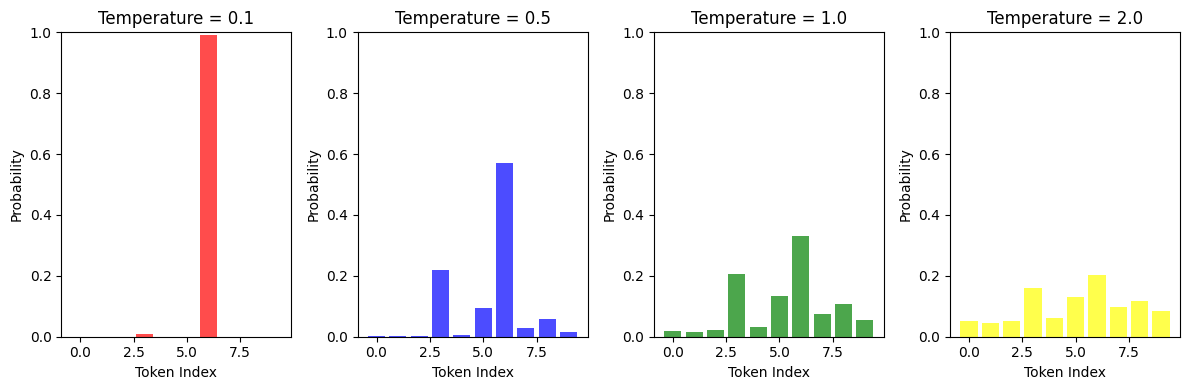

In [21]:
import matplotlib.pyplot as plt
import numpy as np

temperatures = [0.1, 0.5, 1.0, 2.0]
colors = ['red', 'blue', 'green', 'yellow']

plt.figure(figsize=(12, 4))
for i, temp in enumerate(temperatures):
    probs = torch.softmax(logits / temp, dim=0)
    plt.subplot(1, 4, i+1)
    plt.bar(range(10), probs.numpy(), color=colors[i], alpha=0.7)
    plt.title(f'Temperature = {temp}')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [24]:
torch.multinomial(probs, num_samples=3)

tensor([4, 1, 8])

**Top-k 采样**

限制候选词只来自于概率最高的 k 个 token。

- 将概率分布按大小排序。
- 取前 k 个 token，剩下的截断。
- 在这 k 个中重新归一化，再采样。

假设分布是 [猫:0.5, 狗:0.3, 鸟:0.1, 鱼:0.1]，如果 k=2 → 只考虑 {猫, 狗}，重新归一化为 [猫:0.625, 狗:0.375]。Top-k 让模型不会采样到概率特别低的“奇怪”词，但仍保持一定随机性。

**Top-p (Nucleus Sampling)**

动态选择概率累积到 p 阈值的最小候选集。

- 将 token 概率从大到小排序。
- 从前往后累积概率，直到 ≥ p（例如 p=0.9）。
- 只在这部分候选中重新归一化，再采样。
- 例子
	- 概率 [猫:0.5, 狗:0.3, 鸟:0.1, 鱼:0.1]，
	- 如果 p=0.8 → 选 {猫, 狗}（0.5+0.3=0.8），
	- 如果 p=0.95 → 选 {猫, 狗, 鸟}（0.5+0.3+0.1=0.9）。

Top-p 是自适应的，概率分布集中时候选更少，分布均匀时候选更多。

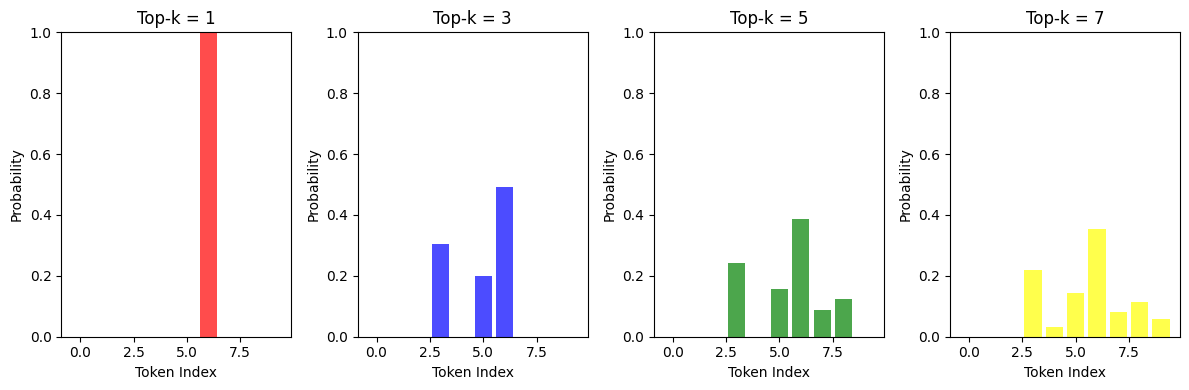

In [53]:
import matplotlib.pyplot as plt

k_values = [1, 3, 5, 7]
colors = ['red', 'blue', 'green', 'yellow']

plt.figure(figsize=(12, 4))
for i, k in enumerate(k_values):
    values, indices = torch.topk(logits, k=k)
    threshold = values[-1]
    filtered = torch.where(logits < threshold, torch.full_like(logits, float("-inf")), logits)
    probs = torch.softmax(filtered, dim=-1)
    plt.subplot(1, 4, i+1)
    plt.bar(range(10), probs.numpy(), color=colors[i], alpha=0.7)
    plt.title(f'Top-k = {k}')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

top-p 的实现会有些技巧。其中的

In [40]:
probs = torch.softmax(logits, dim=-1)
torch.sort(probs, descending=True)

torch.return_types.sort(
values=tensor([0.3321, 0.2061, 0.1349, 0.1074, 0.0757, 0.0556, 0.0309, 0.0208, 0.0204,
        0.0162]),
indices=tensor([6, 3, 5, 8, 7, 9, 4, 2, 0, 1]))

In [42]:
sorted_probs, sorted_idx = torch.sort(probs, descending=True)
torch.cumsum(sorted_probs, dim=-1)

tensor([0.3321, 0.5381, 0.6730, 0.7804, 0.8560, 0.9116, 0.9425, 0.9634, 0.9838,
        1.0000])

In [47]:
p = 0.9
cumsum = torch.cumsum(sorted_probs, dim=-1)
mask = cumsum < 0.9
mask[..., 0] = True # if the first one is false, swap to true
keep_idx = sorted_idx[mask]
keep_idx

tensor([6, 3, 5, 8, 7])

In [54]:
filtered = torch.zeros_like(probs)
filtered[keep_idx] = probs[keep_idx]
filtered / filtered.sum()

tensor([0.0000, 0.0000, 0.0000, 0.2407, 0.0000, 0.1576, 0.3879, 0.0884, 0.1254,
        0.0000])

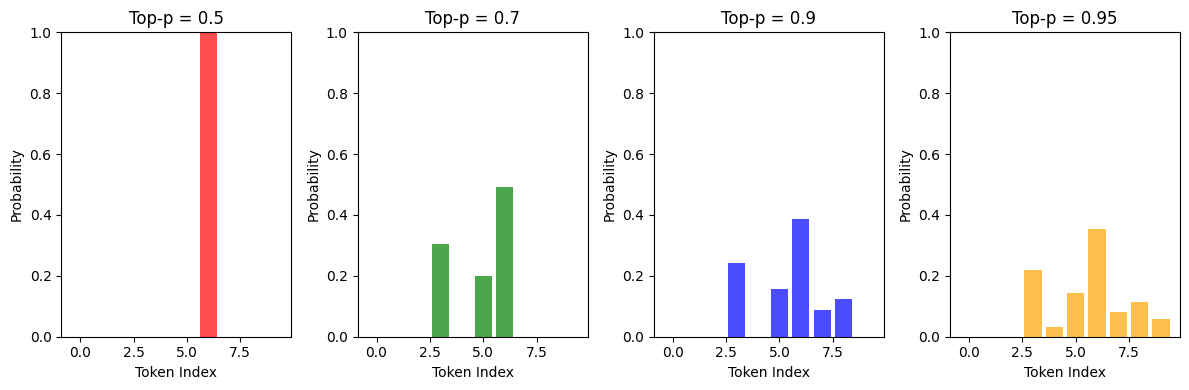

In [56]:
# Visualize different p values for top-p sampling
p_values = [0.5, 0.7, 0.9, 0.95]
colors = ['red', 'green', 'blue', 'orange']

plt.figure(figsize=(12, 4))

for i, p in enumerate(p_values):
    probs = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True)
    cumsum = torch.cumsum(sorted_probs, dim=-1)
    mask = cumsum < p
    mask[..., 0] = True # if the first one is false, swap to true
    keep_idx = sorted_idx[mask]
    filtered = torch.zeros_like(probs)
    filtered[keep_idx] = probs[keep_idx]
    filtered = filtered / filtered.sum()
    
    plt.subplot(1, 4, i+1)
    plt.bar(range(10), filtered.numpy(), color=colors[i], alpha=0.7)
    plt.title(f'Top-p = {p}')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()